In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-25 22:05:28--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.001s  

2025-10-25 22:05:28 (71.4 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [1]:
import pandas as pd
import numpy as np
import requests
import io
from sklearn.model_selection import train_test_split

# --- 1. Load Data Directly from csv ---
df = pd.read_csv('course_lead_scoring.csv')
print(f"The true mean of 'converted' is: {df['converted'].mean():.4f}\n")

# --- 2. Data Preparation ---
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = list(df.dtypes[df.dtypes != 'object'].index)
numerical.remove('converted')

for col in categorical:
    df[col] = df[col].fillna('NA')
for col in numerical:
    df[col] = df[col].fillna(0.0)

# --- 3. Define Features and Target ---
df_features = df[categorical + numerical]
df_target = df['converted']

# --- 4. Split the Data (using random_state=1) ---
# First split: 80% train_full, 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(df_features, df_target, 
                                                              test_size=0.2, 
                                                              random_state=1)
# Second split: 60% train, 20% val (0.25 * 0.8 = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
                                                  test_size=0.25, 
                                                  random_state=1)

print(f"Data split successfully with random_state=1:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"X_test shape:  {X_test.shape}")

The true mean of 'converted' is: 0.6190

Data split successfully with random_state=1:
X_train shape: (876, 8)
X_val shape:   (293, 8)
X_test shape:  (293, 8)


In [2]:
from sklearn.metrics import roc_auc_score

print("--- AUC Feature Importance (on training data) ---")

# Loop through each numerical feature
for col in numerical:
    # Calculate the AUC score
    auc = roc_auc_score(y_train, X_train[col])
    
    # Check if we need to invert the feature
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[col])
        print(f"'{col}' (inverted): {round(auc, 3)}")
    else:
        print(f"'{col}': {round(auc, 3)}")

--- AUC Feature Importance (on training data) ---
'number_of_courses_viewed': 0.764
'annual_income': 0.552
'interaction_count': 0.738
'lead_score': 0.614


In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# 1. Initialize the DictVectorizer
dv = DictVectorizer(sparse=False)

# 2. Prepare the dictionaries for our train and val sets
X_train_dicts = X_train.to_dict(orient='records')
X_val_dicts = X_val.to_dict(orient='records')

# 3. Fit and transform the training data
X_train_encoded = dv.fit_transform(X_train_dicts)

# 4. ONLY transform the validation data
X_val_encoded = dv.transform(X_val_dicts)

# 5. Initialize the model with homework parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

# 6. Train the model
model.fit(X_train_encoded, y_train)

# 7. Get the predicted probabilities for the validation set
# We need the probabilities for the "positive" class (1)
y_pred = model.predict_proba(X_val_encoded)[:, 1]

# 8. Calculate the AUC score
auc = roc_auc_score(y_val, y_pred)

print(f"The AUC of the model on the validation dataset is: {round(auc, 3)}")

The AUC of the model on the validation dataset is: 0.817


In [6]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

# A list to store our results
scores = []

# Generate thresholds from 0.0 to 1.0 with a step of 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# We use the y_pred (probabilities) from the previous question
for t in thresholds:
    # 1. Convert probabilities to 0/1 decisions based on threshold
    y_decision = (y_pred >= t)
    
    # 2. Calculate precision and recall
    # 'zero_division=0' prevents a warning if we never predict a '1'
    precision = precision_score(y_val, y_decision, zero_division=0)
    recall = recall_score(y_val, y_decision)
    
    # 3. Store the scores
    scores.append((t, precision, recall))

# --- Find the intersection point ---
meaningful_diffs = []

# We use the 'scores' list from before
for t, p, r in scores:
    # We only care about points *before* recall drops to 0
    # Let's say, where recall is at least > 0.01
    if r > 0.01 and p > 0.01:
        meaningful_diffs.append((t, abs(p - r)))

# Sort by the difference (smallest first)
meaningful_diffs.sort(key=lambda x: x[1])

# Get the threshold with the smallest *real* difference
best_threshold = meaningful_diffs[0][0]

print(f"The threshold where Precision and Recall are closest is: {best_threshold:.3f}")

The threshold where Precision and Recall are closest is: 0.640


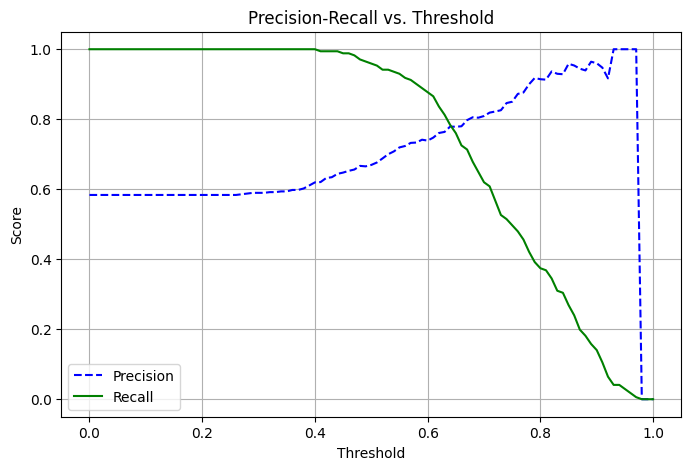

In [7]:
import matplotlib.pyplot as plt

# --- Plotting Code ---

# Get the list of thresholds, precisions, and recalls from our 'scores'
thresholds_list = [item[0] for item in scores]
precision_list = [item[1] for item in scores]
recall_list = [item[2] for item in scores]

# Plot the curves
plt.figure(figsize=(8, 5)) # Set a nice size for the plot
plt.plot(thresholds_list, precision_list, label='Precision', linestyle='--', color='blue')
plt.plot(thresholds_list, recall_list, label='Recall', linestyle='-', color='green')

# Add labels and title
plt.title('Precision-Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True) # Add a grid for easier reading
plt.show()

In [8]:
from sklearn.metrics import f1_score

# A list to store our F1 scores
f1_scores = []

# We use the 'scores' list from before (t, p, r)
for t, p, r in scores:
    
    # We need to re-create the 0/1 decisions for f1_score
    y_decision = (y_pred >= t)
    
    # Calculate the F1 score
    f1 = f1_score(y_val, y_decision)
    
    # Store the threshold and its F1 score
    f1_scores.append((t, f1))

# --- Find the best threshold ---
# Sort the list by F1 score (highest first)
f1_scores.sort(key=lambda x: x[1], reverse=True)

# Get the threshold with the highest F1 score
best_f1_threshold = f1_scores[0][0]
best_f1_score = f1_scores[0][1]

print(f"Max F1 score of {best_f1_score:.4f} found at threshold: {best_f1_threshold:.3f}")

Max F1 score of 0.8125 found at threshold: 0.570


In [9]:
from sklearn.model_selection import KFold

# 1. Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# A list to store the 5 AUC scores
scores = []

# 2. Loop through the 5 folds
# kfold.split gives us the *row indices* for train/val
for train_idx, val_idx in kfold.split(X_train_full):
    
    # 3. Create the data for this fold
    X_train_fold = X_train_full.iloc[train_idx]
    y_train_fold = y_train_full.iloc[train_idx]
    
    X_val_fold = X_train_full.iloc[val_idx]
    y_val_fold = y_train_full.iloc[val_idx]

    # 4. Initialize and fit a new vectorizer
    dv = DictVectorizer(sparse=False)
    X_train_fold_encoded = dv.fit_transform(X_train_fold.to_dict(orient='records'))
    X_val_fold_encoded = dv.transform(X_val_fold.to_dict(orient='records'))

    # 5. Initialize and train a new model
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_fold_encoded, y_train_fold)
    
    # 6. Get predictions and calculate AUC
    y_pred_fold = model_fold.predict_proba(X_val_fold_encoded)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    scores.append(auc)

# 7. Calculate the standard deviation of the 5 scores
std_deviation = np.std(scores)

print(f"AUC scores from 5 folds: {[round(s, 3) for s in scores]}")
print(f"Standard Deviation of scores: {round(std_deviation, 4)}")

AUC scores from 5 folds: [0.806, 0.871, 0.775, 0.802, 0.856]
Standard Deviation of scores: 0.0358


In [10]:
# The list of C values to test
C_values_to_test = [0.000001, 0.001, 1]

# Initialize KFold just like before
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

print("--- Cross-Validating to find best C ---")

# Outer loop: Iterate over C values
for C in C_values_to_test:
    
    fold_scores = [] # A list to store scores for this C
    
    # Inner loop: Iterate over the 5 folds
    for train_idx, val_idx in kfold.split(X_train_full):
        
        # Create data for this fold
        X_train_fold = X_train_full.iloc[train_idx]
        y_train_fold = y_train_full.iloc[train_idx]
        X_val_fold = X_train_full.iloc[val_idx]
        y_val_fold = y_train_full.iloc[val_idx]

        # Fit a new vectorizer
        dv = DictVectorizer(sparse=False)
        X_train_fold_encoded = dv.fit_transform(X_train_fold.to_dict(orient='records'))
        X_val_fold_encoded = dv.transform(X_val_fold.to_dict(orient='records'))

        # Initialize and train a new model *with this C*
        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_train_fold_encoded, y_train_fold)
        
        # Get AUC and append to this C's score list
        y_pred_fold = model_fold.predict_proba(X_val_fold_encoded)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_fold)
        fold_scores.append(auc)

    # After the 5 folds, calculate mean and std for this C
    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    
    print(f"C = {C}:")
    print(f"  Mean AUC = {round(mean_score, 3)}, Std = {round(std_score, 3)}\n")

--- Cross-Validating to find best C ---
C = 1e-06:
  Mean AUC = 0.56, Std = 0.024

C = 0.001:
  Mean AUC = 0.867, Std = 0.029

C = 1:
  Mean AUC = 0.822, Std = 0.036

